# LS88 Project

###   Imports

In [4]:
%matplotlib inline
import numpy as np
import datascience as ds
from datascience import Table, make_array, predicates
import nba_py as py
from nba_py import player
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import random

### Load all the Tables

In [5]:
print("All Games")
all_games = Table().read_table('all_games.csv', sep=',')
all_games.show(5)
print('')

print('Close Games in 4th Quarter, 6 Mintues Left')
close_games_under_six = Table().read_table('PbP_15_16_trimmed.csv', sep=',')
close_games_under_six.show(5)
print('')

print('Row Ranges of Each Game in Close Games')
game_ref = Table().read_table('gamereference.csv', sep=',')
game_ref.show(5)
print('')

print('All Players and their Relevant Stats')
player_ref = Table().read_table('player_ref.csv', sep=',')
player_ref.show(5)
print('')


label_meaning = {}
label_meaning['TS%'] = 'True Shooting Percentage'
label_meaning['EFG%'] = 'Effective Field Goal Percentage'
label_meaning['PER'] = 'ESPN PER Player Rating (A way to rank NBA players)'
label_meaning['3PAr'] = '3 Point Attempt Rate'
label_meaning['G'] = 'Games'
label_meaning['MP'] = 'Minutes Played'
label_meaning['Pos'] = 'Position'
label_meaning

All Games


GAME_ID,EVENTNUM,PCTIMESTRING,TIME,PERIOD,HOME_TEAM,AWAY_TEAM,HOME_SCORE,AWAY_SCORE,POINTS_SCORED,SHOT_MADE,SHOT_TYPE,SHOT_DIST,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_NICKNAME,ASSIST_PLAYER_ID,EVENTMSGTYPE,EVENTMSGACTIONTYPE,Row Number
21500001,0,12:00,0,1,Hawks,Pistons,0,0,0,nan,nan,nan,0,nan,nan,nan,Start Period,nan,0
21500001,1,12:00,0,1,Hawks,Pistons,0,0,0,nan,nan,nan,201143,Al Horford,Hawks,nan,Jumpball,nan,1
21500001,2,11:41,19,1,Hawks,Pistons,0,0,0,0,Layup,2,203083,Andre Drummond,Pistons,nan,Miss,Driving Layup,2
21500001,3,11:39,21,1,Hawks,Pistons,0,0,0,nan,nan,nan,203145,Kent Bazemore,Hawks,nan,Rebound,Player,3
21500001,4,11:37,23,1,Hawks,Pistons,0,0,0,nan,nan,nan,203145,Kent Bazemore,Hawks,nan,Turnover,Out of Bounds - Bad Pass Turnover,4



Close Games in 4th Quarter, 6 Mintues Left


GAME_ID,EVENTNUM,PCTIMESTRING,TIME,PERIOD,HOME_TEAM,AWAY_TEAM,HOME_SCORE,AWAY_SCORE,POINTS_SCORED,SHOT_MADE,SHOT_TYPE,SHOT_DIST,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_NICKNAME,ASSIST_PLAYER_ID,EVENTMSGTYPE,EVENTMSGACTIONTYPE
21500002,474,6:32,6.53333,4,Bulls,Cavaliers,80,79,0,nan,nan,nan,2747,J.R. Smith,Cavaliers,nan,Personal Foul,P.FOUL
21500002,476,6:20,6.33333,4,Bulls,Cavaliers,82,79,2,1,Shot,15,201565,Derrick Rose,Bulls,nan,Make,Pullup Jump Shot
21500002,479,6:01,6.01667,4,Bulls,Cavaliers,82,81,2,1,Dunk,nan,202684,Tristan Thompson,Cavaliers,2590,Make,Dunk
21500002,480,5:50,5.83333,4,Bulls,Cavaliers,82,81,0,0,Layup,2,201565,Derrick Rose,Bulls,nan,Miss,Driving Layup
21500002,481,5:48,5.8,4,Bulls,Cavaliers,82,81,0,nan,nan,nan,201567,Kevin Love,Cavaliers,nan,Rebound,Player



Row Ranges of Each Game in Close Games


HOME_TEAM,AWAY_TEAM,GAME NUMBER,FIRST_INDEX,LAST_INDEX
Bulls,Cavaliers,1,0,69
Magic,Wizards,2,70,149
Celtics,76ers,3,150,224
Pistons,Jazz,4,225,301
Pacers,Raptors,5,302,396



All Players and their Relevant Stats


Player_ID,Player,First_Name,Last_Name,TS%,EFG%,PER,3PAr,G,MP,Pos
201166,Aaron Brooks,Aaron,Brooks,0.49333,0.470588,11.8,0.394,69,1108,PG
203932,Aaron Gordon,Aaron,Gordon,0.541176,0.506757,17,0.245,78,1863,PF
1626151,Aaron Harrison,Aaron,Harrison,0.386598,0.277778,4.3,0.526,21,93,SG
203940,Adreian Payne,Adreian,Payne,0.413907,0.392857,5.6,0.221,52,486,PF
201143,Al Horford,Al,Horford,0.562796,0.550781,19.4,0.244,82,2631,C


{'3PAr': '3 Point Attempt Rate',
 'EFG%': 'Effective Field Goal Percentage',
 'G': 'Games',
 'MP': 'Minutes Played',
 'PER': 'ESPN PER Player Rating (A way to rank NBA players)',
 'Pos': 'Position',
 'TS%': 'True Shooting Percentage'}

# Analysis Begins Here

In [6]:
def shots_all_players(table):
    #This function finds the number of shots that each player takes in time period
    #(it doesn't distinguish the type of shot)
    #it can be used for an entire game or for the last 6 minutes
    shots = table.where('EVENTMSGTYPE', predicates.are.containing('M'))
    players = shots.select('EVENTMSGTYPE', 'PLAYER1_NAME', 'PLAYER1_TEAM_NICKNAME', 'HOME_TEAM', 'AWAY_TEAM')
    count = players.groups(['PLAYER1_NAME', "PLAYER1_TEAM_NICKNAME"])
    return count

def seperate_teams(table):
    #This function creates two tables from the last_six_minutes_table for each team
    return table.group("PLAYER1_TEAM_NICKNAME").column(0)

def max_shot_player_each_team_name(table):
    #This takes in a table of one game (entire game or last 6 minutes)
    #It returns the player who shoots the most for each team
    team_names = seperate_teams(table)
    player_team_one = table.where("PLAYER1_TEAM_NICKNAME", team_names.item(0)).sort('count', descending=True).column('PLAYER1_NAME').item(0)
    player_team_two = table.where("PLAYER1_TEAM_NICKNAME", team_names.item(1)).sort('count', descending=True).column('PLAYER1_NAME').item(0)
    return (player_team_one, player_team_two)

def max_shots(table):
    #This takes in a table of one game (entire game or last 6 minutes)
    #It returns the player who shoots the most for each team
    team_names = seperate_teams(table)
    shots_player_one = table.where("PLAYER1_TEAM_NICKNAME", team_names.item(0)).sort('count', descending=True).column('count').item(0)
    shots_player_two = table.where("PLAYER1_TEAM_NICKNAME", team_names.item(1)).sort('count', descending=True).column('count').item(0)
    return (shots_player_one, shots_player_two)

def total_shot_number(table):
    #returns the number of shots for each team in the last 6 minutes
    team_names = seperate_teams(table)
    total_shots1 = sum(table.where("PLAYER1_TEAM_NICKNAME", team_names.item(0)).column("count"))
    total_shots2 = sum(table.where("PLAYER1_TEAM_NICKNAME", team_names.item(1)).column("count"))
    return (total_shots1, total_shots2)

def average_player_each_team(table):
    #returns the number of shots of the average player
    average_shots1 = np.average(table.where("PLAYER1_TEAM_NICKNAME", team_names.item(0)).column("count"))
    average_shots2 = np.average(table.where("PLAYER1_TEAM_NICKNAME", team_names.item(1)).column("count"))
    return (total_shots1, total_shots2)



In [7]:
max_shots(shots_all_players(close_games_under_six))

(98, 140)

In [8]:
shots_all_players(close_games_under_six)

PLAYER1_NAME,PLAYER1_TEAM_NICKNAME,count
Aaron Brooks,Bulls,34
Aaron Gordon,Magic,35
Aaron Harrison,Hornets,1
Adreian Payne,Timberwolves,1
Al Horford,Hawks,95
Al Jefferson,Hornets,25
Al-Farouq Aminu,Trail Blazers,58
Alan Anderson,Wizards,4
Alec Burks,Jazz,50
Alex Len,Suns,30


In [9]:
close_game_ids = close_games_under_six.group('GAME_ID').column(0)

In [10]:
len(close_game_ids)

689

In [131]:
for i in close_game_ids:
    game = close_games_under_six.where("GAME_ID", i)
    shots = shots_all_players(game)
    max_players = max_shot_player_each_team(shots)
    
    max_proportions = max_players

NameError: name 'max_shot_player_each_team' is not defined

# QUESTION 2

In [51]:
def shot_type(table):
    ## takes in a table and returns counts of how many shots were assisted/not assisted
    
    table = table.where('SHOT_MADE', 1)
    table = table.with_column('ASSIST_PLAYER_ID', table.apply(lambda x: str(x), 'ASSIST_PLAYER_ID'))

    # Create Assist Table
    a = table.where('ASSIST_PLAYER_ID', predicates.are.not_equal_to('nan'))
    a_count = a.num_rows

    # Create Unassisted Table
    ua = table.where('ASSIST_PLAYER_ID', predicates.are.equal_to('nan'))
    ua_count = ua.num_rows
    
    return [a_count, ua_count]

def prort(a, ua):
    try:
        p = ua /(a + ua)
    except ZeroDivisionError:
        p = 0 
    return p

def distance(p1, p2):
    return abs(p1 - p2)

def game_by_game(games, game_indicies):
    #takes in the games table and the game indicies table, isolates all games 1 by 1, 
    #and calcs the test statistic.
    shots = make_array()
    for i in np.arange(game_indicies.num_rows):
        rowi = game_indicies.row(i)
        i1 = int(rowi.item(3))
        i2 = int(rowi.item(4))
        gamei = games.take(np.arange(i1, i2))
        a_and_u = shot_type(gamei)
        a = a_and_u[0]
        au = a_and_u[1]
        p = prort(a, au)
        shots = np.append(p[1], shots)
    return shots
                      

In [ ]:
shot_type(close_games_under_six)
x = game_by_game(close_games_under_six, game_ref)
# FIX THIS
y = game_by_game(all_games, game_ref)
t = Table().with_columns('Close Games', x, 'All Games', y)
t.hist()

In [56]:
#Helper...
def test(floatz1):
    x = str(floatz1)
    y = x.split('.')
    if(y[1] == '0'):
        time = str(floatz1).replace('.', ':') + '0'
    else:
        time = str(floatz1).replace('.', ':')
    return time


#Helper...
def six_minute_period(timestamp):
    floatz = float(timestamp.replace(':', '.'))
    if floatz > 6:
        endpoint1 = "{0:.2f}".format(floatz - 6) 
    else:
        endpoint1 = "{0:.2f}".format(floatz + 6) 
    return test(endpoint1)


#Helper...
def out_back_steakhouse_minus(timestamp):
    split = timestamp.split(':')
    if split[1] == '00':
        part_minus = str(int(split[0]) - 1) + ':' + '59'
    else:
        if int(split[1]) < 11:
            part_minus = split[0] + ':' + '0' + str(int(split[1]) - 1) 
        else:
            part_minus = split[0] + ':' + str(int(split[1]) - 1)    
    return part_minus

#Helper...
def out_back_steakhouse_plus(timestamp):
    split = timestamp.split(':')
    if split[1] == '59':
        part_plus = str(int(split[0]) + 1) + ':' + '00'
    elif split[1] == '00':
        part_plus = split[0] + ':' + '01'
    else:
        if int(split[1]) < 9:
            part_plus = split[0] + ':' + '0' + str(int(split[1]) + 1) 
        else:
            part_plus = split[0] + ':' + str(int(split[1]) + 1) 
    return part_plus

#Helper...
def check_validity(time):
    if float(time.replace(':', '.')) < 0:
        return False
    if float(time.replace(':', '.')) > 12:
        return False
    return True

#Helper...
def find_valid_row_more(time, dist, table):
    if not check_validity(time):
        return null
    print(time)
    if table.where('PCTIMESTRING', time).num_rows > 0:
        return [time, dist]
    return find_valid_row_more(out_back_steakhouse_plus(time), dist + 1, table)
        
#Helper...
def find_valid_row_less(time, dist, table):
    if not check_validity(time):
        return null
    if table.where('PCTIMESTRING', time).num_rows > 0:
        return [time, dist]
    return find_valid_row_less(out_back_steakhouse_minus(time), dist + 1, table)
    
        
#YES FINALLY WHAT I WANTED LMAO
def find_closest_endpoint(table, timestamp):
    endpoint = six_minute_period(timestamp)
    less = find_valid_row_less(endpoint, 0, table)
    more = find_valid_row_more(endpoint, 0, table)
    if (less[1] < more[1]):
        return less[0]
    return more[0]
        
print(out_back_steakhouse_plus('8:09'))

8:10


In [53]:
def calc_test_statistic(table):
    a_and_u = shot_type(table)
    a = a_and_u[0]
    au = a_and_u[1]
    p = prort(a, au)
    return p

def get_six_minute_interval(anyz, last_six, gr_all, gr_last):
    
    # get a random game from all games.
    rowi = random.randint(0, gr_all.num_rows - 1)
    rand_game_id = gr_all.row(rowi).item('GAME_ID')
    game = anyz.where('GAME_ID', rand_game_id)

    # get a randoom quarter from that game
    quarter = random.randint(1, 4)
    game = game.where('PERIOD', quarter)

    # Get a random start timestamp
    row_game = game.row(random.randint(0, game.num_rows - 1))
    row_number_start = row_game.item(game.num_columns - 1)
    time_start = row_game.item('PCTIMESTRING')

    # find the 6 minute endpoint timestamp.
    time_endpoint = find_closest_endpoint(game, time_start)

    # take just that (approx) 6 minute interval of the table
    row_number_end = game.where('PCTIMESTRING', time_endpoint).row(0).item(anyz.num_columns - 1)
    if row_number_end > row_number_start:
        six_min_slice = anyz.take(np.arange(row_number_start, row_number_end + 1))
    else:
        six_min_slice = anyz.take(np.arange(row_number_end, row_number_start + 1))

    return six_min_slice

def calculate(anyz, last_six, gr_all, gr_last):
    
    anyone = make_array()
    lastones = make_array()
    
    for i in np.arange(gr_last.num_rows):
        print('Iteration Count is: ' + str(i))
        
        six_minutes = get_six_minute_interval(anyz, last_six, gr_all, gr_last)
        
        # calculate the test statistic
        kappa = calc_test_statistic(six_minutes)
        
        # append test statistic to array
        print('Test statistic ANY 6 is: ' + str(kappa))
        anyone = np.append(kappa, anyone)

        # get a random 6 minute period from all close games.
        row1 = random.randint(0, gr_last.num_rows - 1)
        first1 = int(gr_last.row(row1).item('FIRST_INDEX'))
        last1 = int(gr_last.row(row1).item('LAST_INDEX'))
        game1 = last_six.take(np.arange(first1, last1 + 1))
        
        # calcualte the test statistic 
        last = calc_test_statistic(game1)
        print('Test statistic LAST 6 is : ' + str(last))
        lastones = np.append(last, lastones)
        
        print('')
        print('NEW ITERATION')
        print('')
            
    both = Table().with_columns('Last 6', lastones, 'Any 6', anyone)
    return both


In [64]:
# table_x_1 = calculate(all_games, close_games_under_six, all_games.group('GAME_ID'), game_ref)
# table_x_1.to_csv('question_2_1.csv')

In [61]:
table_x_1

Last 6,Any 6
0.454545,0.375
0.5,0.454545
1,0.3
0.2,0.5
0.666667,0.25
0.5,0.363636
0.416667,0.555556
0.461538,0.214286
0.272727,0.272727
0.375,0.636364


Average of Last 6: 0.4729005670951635
Median of Last 6: 0.46153846153846156
STD of Last 6: 0.18135903801761316
 
 
 
Average of Any 6: 0.412581659130693
Median of Any 6: 0.4
STD of Any 6: 0.16459841022435334


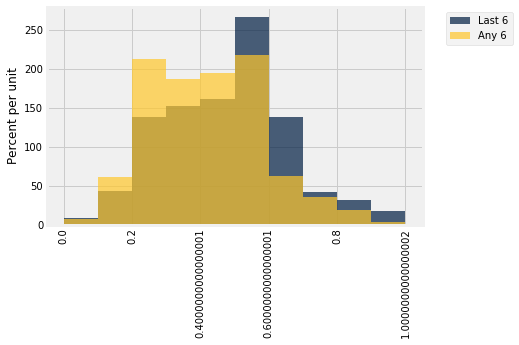

In [83]:
table_x_1.hist()
last_6 = table_x_1.column('Last 6')
any_6 = table_x_1.column('Any 6')

print('Average of Last 6: ' + str(np.mean(last_6)))
print('Median of Last 6: ' + str(np.median(last_6)))
print('STD of Last 6: ' + str(np.std(last_6)))

print(' ')
print(' ')
print(' ')

print('Average of Any 6: ' + str(np.mean(any_6)))
print('Median of Any 6: ' + str(np.median(any_6)))
print('STD of Any 6: ' + str(np.std(any_6)))



# QUESTION 2 PART 2

## Goal: Figure out if more unassited or assited shots are taken in last 6 on a team by team basis

In [69]:
def split_game_teams(table):
# This function is a helper takes a game and splits it into two tables, one for shots taken by each team
    return null


def team_bins(last, last_ref):
    ## Write a function that:
    # Iterates through each game in last games
    # For each game:
         # Call split_game_teams to split the game
         # Calculate test statistic for each table returned by split_game_teams: (u/(u+a))
         # Store this in the team array. There should be 30 arrays for 30 teams. Each array should be of length 82.
    # put all these arrays as columns in a 30 column table, and return that table
    return null
        

# For testing the team_bins
def test_team_bins(team_table):
    assert team_table.num_columns == 30, 'Team number ' + str(team_table.num_columns) + ' should be 30'
    assert team_table.num_rows == 82, 'Games number ' + str(team_table.num_columns) + ' should be 82'
    for c in np.arange(0, 30):
        for r in np.arange(0, 82):
            assert team_table.column(c).item(r) <= 1 and team_table.column(c).item(r) >= 0, 'column ' + srt(c) + 'row ' + srt(r) + ' proportion is invalid'
    print('Table passed!')
    return null


# QUESTION 3

In [60]:
def best_player_last_six(allz, last, last_ref, all_ref):
    # This function takes in the last_six table, 
        # for each game in last:
            # calls split_game_teams
            # determines the best player for each table returned by split_game_teams
            # for each table returned:
                # calculates (u/(u+a)) just for best player only in the last 6 minutes.
                # calculates (u/(u+a)) for all other players only in the last 6 minutes.
                # calculates (u/(u+a)) for all players in the last 6 minutes.
                # calculates (u/(u+a)) for all other players in the entire game.
                # calculates (u/(u+a)) for all players in the entire game.
    # returns a table with 30 columns
        # column 1: Game Number
        # column 2: Team Name
        # column 3: Best Player
        # column 4: (u/(u+a)) just for best player only in the last 6 minutes.
        # column 5: (u/(u+a)) for all other players only in the last 6 minutes.
        # column 6: (u/(u+a)) for all players in the last 6 minutes.
        # column 7: (u/(u+a)) for all other players in the entire game.
        # column 8: (u/(u+a)) for all players in the entire game.
    return null


def test_best_player_last_six(best_games):
    #tests the best_player_function
    assert best_games.num_columns == 8, 'Column number ' + str(best_games.num_columns) + ' should be ' + str(8)
    assert best_games.num_rows == game_ref.num_rows * 2, 'Row number ' + str(best_games) + ' should be ' + str(game_ref.num_rows * 2)


            

